# Adversarial Example Task

This preliminary work seeks to provides steps for 3 tasks:

    1-Image classification using pre-trained Deep Neural Network Inception v3.
    
    2-Attacking the neural network.
    
    3-Imperceptible adversarial examples.
    
In this task, first, we load a pre-trained Inception v3 network from the TF-slim image classification library and use it for prediction.Then, this model is used to attack. Results and discussion about adversarial example are addressed in following sections.



## Software Prerequisites

Python 3+

Linux Ubuntu 16.04

## Install Python Packages(with sudo permission)

In [ ]:
!pip install numpy
!pip install tensorflow==1.14
!pip install matplotlib


## Loading Packages

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
from PIL import Image
from urllib.request import urlretrieve
import zipfile
import tarfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import json
tf.logging.set_verbosity(tf.logging.ERROR)


In [3]:
tf.__version__

'1.14.0'

## Various directories

In [4]:
# Internet URL for the tar-file with the Inception model.
model_url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'

# Directory to store the downloaded data.
model_dir = "InceptionV3/"

# Internet URL of imagenet
imagenet_url = 'http://www.anishathalye.com/media/2017/07/25/imagenet.json'


## Download the Inception Model


The Inception model is downloaded from the internet. The directory to save the model will be created if it does not exist.

In [5]:

def download_model(url, download_dir):
    """
    Download and extract the inception model from the internet if it does not
    exist in model_dir
    
    url: Internet url for downloading the model
    download_dir: directory for saving the model
    
    """

    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urlretrieve(url=url,filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")



In [6]:
# Test  download_model function
download_model(model_url, model_dir)


Download finished. Extracting files.
Done.


## Load Imagenet to map the predicted class to name of class

In [7]:
imagenet_json, _ = urlretrieve(imagenet_url)
    
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

## Define Inception class for classification and adversarial example

The Inception model is a Deep Neural Network which has already been
trained for classifying images into 1000 different categories.
I use pre-trained Inception v3 for classifying images.
First an image for a jpeg-file which will be
loaded as an input to the Inception model, which will then output
an array of numbers indicating how likely it is that the
input-image is of each class (def inception).

After that, function classify_visualize is used to show an image and classification result (Task1).



In [8]:
class Inception():
    def __init__(self): 
                
        self.sess = tf.InteractiveSession()

        #We use a tf.Variable instead of a tf.placeholder 
        #because we will need it to be trainable for adversarial example
        self.image = tf.Variable(tf.zeros((299, 299, 3)))
     
        
    # Load the inception v3 model
    def inception(self, image, reuse):
        """
        image: array of an image
        reuse: True or tf.AUTO_REUSE for sharing the variables  
        """
        
        preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
        arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
        with slim.arg_scope(arg_scope):
            logits, _ = nets.inception.inception_v3(
                preprocessed, 1001, is_training=False, reuse=reuse)
            logits = logits[:,1:] # ignore background class
            probs = tf.nn.softmax(logits) # probabilities
        return logits, probs

    
    def classify_visualize(self, img, correct_class=None, target_class=None):
        """
        ###### Task1
        this function show the output of classification
        img: image as an array
        correct_class: int as class of input
        target class:
        
        """
        # load pretrained weight of inception v3
        logits, probs = self.inception(self.image, reuse=tf.AUTO_REUSE)
        restore_vars = [var for var in tf.global_variables() 
                        if var.name.startswith('InceptionV3/')]
        saver = tf.train.Saver(restore_vars)
        saver.restore(self.sess, os.path.join(model_dir, 'inception_v3.ckpt'))
        
        #show input image, classify it, and show the classification result
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
        fig.sca(ax1)
        p = self.sess.run(probs, feed_dict={self.image: img})[0]
        ax1.imshow(img)
        fig.sca(ax1)

        topk = list(p.argsort()[-10:][::-1])
        topprobs = p[topk]
        barlist = ax2.bar(range(10), topprobs)
        if target_class in topk:
            barlist[topk.index(target_class)].set_color('r')
        if correct_class in topk:
            barlist[topk.index(correct_class)].set_color('g')
        plt.sca(ax2)
        plt.ylim([0, 1.1])
        plt.xticks(range(10),
                   [imagenet_labels[i][:15] for i in topk],
                   rotation='vertical')
        fig.subplots_adjust(bottom=0.2)
        plt.show()
        
        
    def close(self):
        """
        Call this function when you are done using the Inception model.
        It closes the TensorFlow session to release its resources.
        """

        self.sess.close()
        
        
    def adversarial_example(self, img, demo_target):
        """
        #### Task2 and Task3
        This function synthesize an adversarial example.
        img: input image
        demo_target: the class that We arbitrarily 
        choose as our target class
        """
        
        # Load pretrain model weight
        logits, probs = self.inception(self.image, reuse=tf.AUTO_REUSE)
        restore_vars = [var for var in tf.global_variables() 
                        if var.name.startswith('InceptionV3/')]
        saver = tf.train.Saver(restore_vars)
        saver.restore(self.sess, os.path.join(model_dir, 'inception_v3.ckpt'))
        
        
        #initialization
        x = tf.placeholder(tf.float32, (299, 299, 3))
        x_hat = self.image # our trainable adversarial input
        assign_op = tf.assign(x_hat, x)
        
        # gradient descent step to maximize the log probability of the target class
        learning_rate = tf.placeholder(tf.float32, ())
        y_hat = tf.placeholder(tf.int32, ())

        labels = tf.one_hot(y_hat, 1000)
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
        optim_step = tf.train.GradientDescentOptimizer(
            learning_rate).minimize(loss, var_list=[x_hat])
        
        epsilon = tf.placeholder(tf.float32, ())

        below = x - epsilon
        above = x + epsilon
        projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
        with tf.control_dependencies([projected]):
            project_step = tf.assign(x_hat, projected)
        
        demo_epsilon = 2.0/255.0 # a really small perturbation
        demo_lr = 1e-1
        demo_steps = 100

        # initialization step
        self.sess.run(assign_op, feed_dict={x: img})

        # projected gradient descent
        for i in range(demo_steps):
            # gradient descent step
            _, loss_value = self.sess.run(
                [optim_step, loss],
                feed_dict={learning_rate: demo_lr, y_hat: demo_target})
            # project step
            self.sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
            if (i+1) % 10 == 0:
                print('step %d, loss=%g' % (i+1, loss_value))
                
        adv = x_hat.eval() # retrieve the adversarial example
        return adv
    
    
   

### Task 1 - Inference

Data has apparently already been downloaded and unpacked.


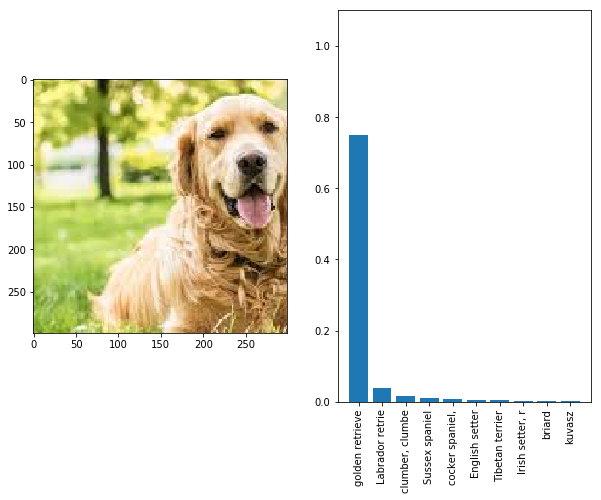

In [9]:
if __name__ == '__main__':
    
    # Download the Inception model if not exist
    download_model(model_url, model_dir)

    # Load the Inception model.
    model = Inception()
    
    ############################################# Task1 
    #load an image and classify it
    # Path for a jpeg-image.
    img_path = "dog.jpeg"
    img_class = 281
    img = Image.open(img_path)
    big_dim = max(img.width, img.height)
    wide = img.width > img.height
    new_w = 299 if not wide else int(img.width * 299 / img.height)
    new_h = 299 if wide else int(img.height * 299 / img.width)
    img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
    img = (np.asarray(img) / 255.0).astype(np.float32)


    # Use the Inception model to classify the image.
    model.classify_visualize(img, correct_class=img_class)
    
 


### Task 2 - Attacking the Neural Network

Q1: Which nodes in the tensorflow computation graph are necessary to solve this excercise?

Further to above question and in term of TensorFlow graph we could list adversarial example types as below and mention which part of graph are used for adversarial example :

White-box: In this term, adversarial perturbations are totally aware of model settings. The adversary and potential perturbations is totally aware of details in model and internal procedures.    

• Output-transparent Black-box: This framework is a bit different from previous definition. The attack cannot go for parameters retrieval. However, it could observe output possibilities from last layer or the layers before than called Logits.
 
• Query-limited Black-box: This strategy is a bit about full observation. It cannot access parameters but modules outputs for limited inputs are accessible to be tracked.

• Label-only Black-box: Neither parameters nor Logits are not accessible. This strategy acting roughly as a black box. Adversarial perturbations could access to final classification decisions. It means merely arg-max layer is out of box to be observed .

• (Full) Black-box: None of above outputs are accessible. As an obvious result, all combinations and dversarial perturbations computations have to be done without any acknowledgement and possible query from targeted model.

  
 =======================================================================================

Q2: What different approaches already exist in the literature to solve this excercise? Give some examples.


There are two categories of adversarial example attacks: target attack and un-target attack.
For the target attack, it attempts to misclassify a sample to
a specific class, while un-target attack only tries to misclassify the input. As a result, the target attack is more difficult
than the un-target one.

There are several algorithms which can generate adversarial examples effectively for
a given model.

1-L-BFGS Attack

2-Fast Gradient Sign Method (FGSM)

3-Basic Iterative Method (BIM) and Iterative Least-Likely Class Method (ILLC)

4-CPPN EA Fool

5-DeepFool

6-Jacobian-based Saliency Map Attack (JSMA)

7-C&W’s Attack

ref: Adversarial Examples: Attacks and Defenses for Deep Learning

===================================================================================

Q3: Are there already open source repositories that are doing that? Give some examples.

1-https://github.com/tensorflow/cleverhans
    
2-https://github.com/bethgelab/foolbox
    
3-https://github.com/advboxes/AdvBox
    
4-https://github.com/BorealisAI/advertorch 


====================================================================================

In the second step, I create an adversarial example for inception by adding some noise (def adversarial_example). It classifiy "golden retrieve" as "guacamole" wrongly. The result visualize in the next section.

step 10, loss=0.0264438
step 20, loss=0.00260633
step 30, loss=0.00174049
step 40, loss=0.00138521
step 50, loss=0.00116709
step 60, loss=0.00101717
step 70, loss=0.000903913
step 80, loss=0.000817799
step 90, loss=0.000749784
step 100, loss=0.000695344


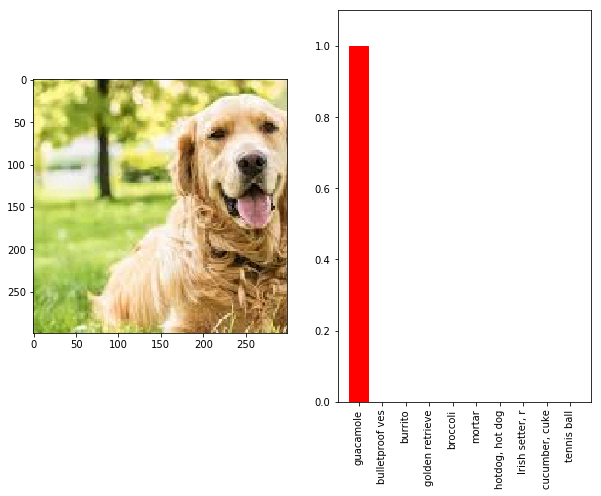

In [10]:
################################## Task 2 
# adversarial example: Target attack
demo_target = 924 # "guacamole"
adv = model.adversarial_example(img, demo_target=demo_target)
model.classify_visualize(adv, correct_class=img_class, target_class=demo_target)

# Close the TensorFlow session.
model.close()  


## Task3- Imperceptible adversarial examples

Q1 : Think about the term imperceptibility of an adversarial example:

Further to discussion, in this task, adversarial event are being addressed with changes 
and modification with input data to cause supervised mis-classification.
The imperceptibility is a term that these changes are not obvious by human to track and 
modifications only cause machine learning parameters settings and training 
leads to detect wrongly on purpose.

In broadly speaking , different concepts for Imperceptibility are found as below:

--Lp-based Imperceptibility: changes and modifications using Lp-Norm are not very tangible
    to be tracked by the human observer and adversarial perturbation only would be
    recognized after classification outcome.

-- Attention-based Imperceptibility: These sort of changes are likely as explained
    previous patagraph but not cuaused by Lp-Norm. This adversarial perturbations are the result and 
    consequence of measures of perceptual similarity such as addressed in rotations
    and translations, Wasserstein distance or SSIM.
    
Ref:  https://arxiv.org/pdf/1906.07077.pdf

=================================================================================    
    
 Q3:
What is input imperceptibility for an adversarial example?

Adversarial attacks can be addressed as a result of optimization 
approach with combination of its own problems (raw data). In simple word,
adversarial perturbation will be generated by selected optimization method
and its own data to create an attack. So input for designing a desired adversarial
perturbation is specific input data point and optimization methods.
   
==================================================================================

Q3: What is output imperceptibility for an adversarial example?

Since output imperceptibility for an adversarial example only targets
mis-classification with fooling it, it is very obvious that sort of these
aforementioned changes are very insignificant, minimal and not be detected
and even easily tracked with human visual sense. Its objective to train 
machine learning parameters to classify false positive or false negative when
irregularities and changes are trivial and easily not worth considering by mistakes.


===================================================================================


Q4: How can I create imperceptible adversarial examples?

We should choose a imperceptibility metric guides us with
how many perturbations can be added without being detected. Then by optimization method we can maximize the noise tolerance
of adversarial examples to improve the success attack rate.


===================================================================================

Q5: Which nodes of the tensorflow computation graph are needed to fullfill that task?

Since generating adversarial examples requires back-propagation of the adversarial loss, all nodes in graph are needed to fulfill that task.

====================================================================================

 Previous attacks for Task 2 is kind of imperceptible attack
 which could be not detected by human eyes.